In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input, concatenate, SeparableConv2D, Activation, Lambda
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


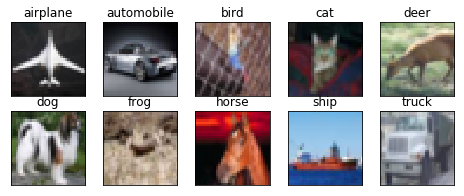

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def space_to_depth(x):
  return tf.space_to_depth(x, block_size=2)

In [30]:
inputs = Input(shape=(32,32,3))

#layer1
layer1 = SeparableConv2D(32, (5,5), activation='relu',name="conv1", border_mode='same')(inputs) 
layer1 = BatchNormalization()(layer1)
skip_conn_layer1 = layer1

#layer2
layer2 = Convolution2D(64, (5,5),activation='relu', name="conv2",border_mode='same')(layer1)
layer2 = BatchNormalization()(layer2)
skip_conn_layer2 = layer2
skip_conn_layer2 = Lambda(space_to_depth)(skip_conn_layer2)

#transiton block
layer2 = Convolution2D(16, (1,1),activation='relu', name="conv2_1",border_mode='same')(layer2)
layer2 = BatchNormalization()(layer2)

#layer3
layer3 = Convolution2D(64, (5,5),activation='relu', name="conv3",border_mode='same')(layer2)
layer3 = BatchNormalization()(layer3)
skip_conn_layer3 = layer3
skip_conn_layer3 = Lambda(space_to_depth)(skip_conn_layer3)
layer3 = concatenate([layer3, skip_conn_layer1],axis=-1)

#transiton block
layer3 = Convolution2D(16, (1,1),activation='relu', name="conv3_1",border_mode='same')(layer3)
layer3 = BatchNormalization()(layer3)

#layer4
layer4 = SeparableConv2D(64, (5,5), activation='relu',name="con4", border_mode='same')(layer3) 
layer4 = BatchNormalization()(layer4)
skip_conn_layer4 = layer4
skip_conn_layer4 = Lambda(space_to_depth)(skip_conn_layer4)
layer4 = concatenate([layer4, skip_conn_layer1],axis=-1)

#maxpooling
pool_1 = MaxPooling2D(pool_size=(2,2),strides=(2,2),border_mode='valid',name='pool1')(layer4) 

#transiton block
pool_1 = Convolution2D(16, (1,1),activation='relu', name="con_pool_1",border_mode='same')(pool_1)
pool_1 = BatchNormalization()(pool_1)

#layer5
layer5 = SeparableConv2D(128, (3,3), activation='relu',name="conv5", border_mode='same')(pool_1) 
layer5 = BatchNormalization()(layer5)
skip_conn_layer5 = layer5
skip_conn_layer1 = Lambda(space_to_depth)(skip_conn_layer1)
layer5 = concatenate([layer5, skip_conn_layer1],axis=-1)

#transiton block
layer5 = Convolution2D(16, (1,1),activation='relu', name="conv5_1",border_mode='same')(layer5)
layer5 = BatchNormalization()(layer5)

#layer6
layer6 = Convolution2D(128, (5,5),activation='relu', name="conv6",border_mode='same')(layer5)
layer6 = BatchNormalization()(layer6)
skip_conn_layer6 = layer6
layer6 = concatenate([layer6, skip_conn_layer3,skip_conn_layer5,skip_conn_layer4],axis=-1)

#transiton block
layer6 = Convolution2D(16, (1,1),activation='relu', name="conv6_1",border_mode='same')(layer6)
layer6 = BatchNormalization()(layer6)

#layer7
layer7 = SeparableConv2D(128, (3,3), activation='relu',name="conv7", border_mode='same')(layer6) 
layer7 = BatchNormalization()(layer7)
skip_conn_layer7 = layer7
layer7 = concatenate([layer7, skip_conn_layer1,skip_conn_layer3,skip_conn_layer4,skip_conn_layer5,skip_conn_layer6],axis=-1)

#transiton block
layer7 = Convolution2D(16, (1,1),activation='relu', name="conv7_1",border_mode='same')(layer7)
layer7 = BatchNormalization()(layer7)

#layer8
layer8 = SeparableConv2D(128, (5,5), activation='relu',name="conv8", border_mode='same')(layer7) 
layer8 = BatchNormalization()(layer8)
skip_conn_layer8 = layer8
layer8 = concatenate([layer8, skip_conn_layer1,skip_conn_layer4,skip_conn_layer5,skip_conn_layer7],axis=-1)

#maxpooling
pool_2 = MaxPooling2D(pool_size=(2,2),strides=(2,2),border_mode='valid',name='pool2')(layer8) 
skip_conn_layer6 = Lambda(space_to_depth)(skip_conn_layer6)
pool_2 = concatenate([pool_2, skip_conn_layer6],axis=-1)

#transiton block
pool_2 = Convolution2D(16, (1,1),activation='relu', name="conv_pool_2_1",border_mode='same')(pool_2)
pool_2 = BatchNormalization()(pool_2)

#layer9
layer9 = Convolution2D(128, (5,5),activation='relu', name="conv9",border_mode='same')(pool_2)
layer9 = BatchNormalization()(layer9)
skip_conn_layer9 = layer9
skip_conn_layer1 = Lambda(space_to_depth)(skip_conn_layer1)
skip_conn_layer2 = Lambda(space_to_depth)(skip_conn_layer2)
skip_conn_layer8 = Lambda(space_to_depth)(skip_conn_layer8)
layer9 = concatenate([layer9, skip_conn_layer1,skip_conn_layer2,skip_conn_layer8],axis=-1)

#transiton block
layer9 = Convolution2D(16, (1,1),activation='relu', name="conv2_9",border_mode='same')(layer9)
layer9 = BatchNormalization()(layer9)

#layer10
layer10 = SeparableConv2D(64, (5,5), activation='relu',name="conv10", border_mode='same')(layer9) 
layer10 = BatchNormalization()(layer10)
skip_conn_layer10 = layer10
skip_conn_layer3 = Lambda(space_to_depth)(skip_conn_layer3)
skip_conn_layer5 = Lambda(space_to_depth)(skip_conn_layer5)
layer10 = concatenate([layer9, skip_conn_layer2,skip_conn_layer3,skip_conn_layer5,skip_conn_layer9],axis=-1)

#transiton block
layer10 = Convolution2D(16, (1,1),activation='relu', name="conv10_1",border_mode='same')(layer10)
layer10 = BatchNormalization()(layer10)

#layer11
layer11 = Convolution2D(128, (3,3),activation='relu', name="conv11",border_mode='same')(layer10)
layer11 = BatchNormalization()(layer11)
skip_conn_layer11 = layer11
skip_conn_layer4 = Lambda(space_to_depth)(skip_conn_layer4)
layer11 = concatenate([layer11, skip_conn_layer1,skip_conn_layer3,skip_conn_layer4,skip_conn_layer5,skip_conn_layer6,skip_conn_layer10],axis=-1)

#transiton block
layer11 = Convolution2D(16, (1,1),activation='relu', name="conv11_1",border_mode='same')(layer11)
layer11 = BatchNormalization()(layer11)

#layer12
layer12 = SeparableConv2D(128, (5,5), activation='relu',name="conv12", border_mode='same')(layer11) 
layer12 = BatchNormalization()(layer12)
skip_conn_layer7 = Lambda(space_to_depth)(skip_conn_layer7)
layer12 = concatenate([layer12, skip_conn_layer4,skip_conn_layer7, skip_conn_layer10])

layer13 = Convolution2D(10, (8,8))(layer12)
flatten = Flatten()(layer13)
output = Activation('softmax',name='prob')(flatten)
model = Model(inputs=inputs, outputs=output)

print(model.summary())


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (SeparableConv2D)         (None, 32, 32, 32)   203         input_17[0][0]                   
__________________________________________________________________________________________________
batch_normalization_173 (BatchN (None, 32, 32, 32)   128         conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 32, 32, 64)   51264       batch_normalization_173[0][0]    
__________________________________________________________________________________________________
batch_norm

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 63s 162ms/step - loss: 13.5239 - acc: 0.1554 - val_loss: 13.7008 - val_acc: 0.1481
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
390/390 [==============================] - 52s 133ms/step - loss: 13.6426 - acc: 0.1523 - val_loss: 13.4403 - val_acc: 0.1651
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
390/390 [==============================] - 51s 131ms/step - loss: 13.2078 - acc: 0.1795 - val_loss: 13.5069 - val_acc: 0.1615
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
390/390 [==============================] - 51s 132ms/step - loss: 12.7061 - acc: 0.2105 - val_loss: 12.2374 - val_acc: 0.2394
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
390/390 [==============================] - 52s 133ms/step - loss: 12

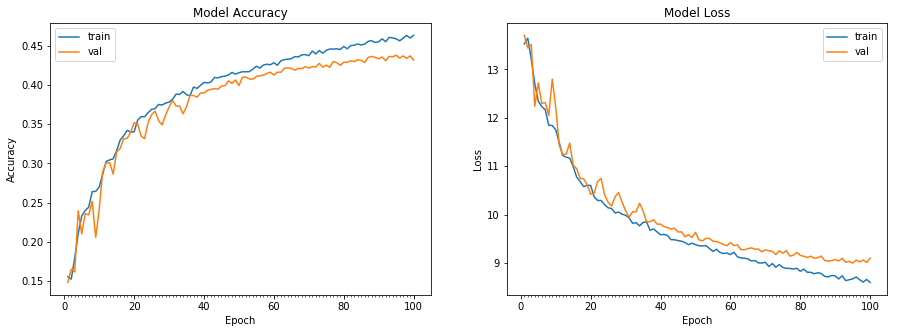

Accuracy on test data is: 43.18


In [33]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100,
                                 callbacks=[LearningRateScheduler(scheduler, verbose=1)], 
                                 validation_data = (test_features, test_labels),verbose=1)                             
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))